In [218]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import export_text, plot_tree, DecisionTreeClassifier, export_graphviz


In [219]:
df1 = pd.read_csv('tmdb_5000_movies.csv') # read the csv-files
df2 = pd.read_csv('tmdb_5000_credits.csv', usecols = ['cast'])
df = pd.concat([df1, df2], axis=1) # join the datasets
print(df.shape)

(4803, 21)


In [220]:
clean = df.drop(columns=['spoken_languages','original_title','id','overview','production_countries','tagline','status','keywords'])

clean = clean.drop(clean[clean.budget<1000].index) # remove movies that don't have budget data
clean = clean.drop(clean[clean.revenue==0].index) # remove movies that don't have revenue data or the data is faulty
clean = clean.drop(clean[clean.vote_average==0].index) # remove movies that don't have rating data (no movie actually has a 0 rating)
clean = clean.drop(clean[clean.genres=='[]'].index) #remove movies that are missing genre information
clean = clean.drop(clean[clean.production_companies=='[]'].index) #remove movies that are missing production company information
clean = clean.drop(clean[clean.cast=='[]'].index) #remove movies that are missing cast information
clean = clean.reset_index(drop=True) #reset indexing

clean['net_income'] = clean['revenue'] - clean['budget'] # add column 'net_income'
clean['profit'] = np.where(clean['net_income']>0, 1, 0) # binary data on whether the movie made profit or not

clean['homepage'] = clean['homepage'].fillna('None')
clean['has_webpage'] = np.where(clean['homepage']=='None', 0, 1) # binary data on whether the movie has a website or not

clean['foreign_language'] = np.where(clean['original_language']=='en', 0, 1) # is the movie in English or a 'foreign language'

clean['release_date'] = pd.to_datetime(clean.release_date, format='%Y-%m-%d') # transform str to datetime
clean['quarter'] = clean['release_date'].dt.quarter # add column for the quarter the movie was released in
clean['month'] = clean['release_date'].dt.month_name() # add column for the month the movie was released in

# assigning a star rating to simplify data
clean['star_rating'] = np.where(clean['vote_average']>8, '5', 
                               np.where(clean['vote_average']>6, '4', 
                                       np.where(clean['vote_average']>4, '3', 
                                               np.where(clean['vote_average']>2, '2',
                                                       np.where(clean['vote_average']>0, '1', False)))))

#extract main genre from nested json structure
stdf = clean['genres'].apply(json.loads)
genres = pd.DataFrame(stdf.tolist())
temp_list = genres.iloc[:,0].to_numpy()
genre_list = []
i = 0
while i < temp_list.size:
    genre_list.append(temp_list[i]['name'])
    i += 1
clean['genre'] = genre_list

#extract production studio from nested json structure
stdf = clean['production_companies'].apply(json.loads)
prodco = pd.DataFrame(stdf.tolist())
temp_list = prodco.iloc[:,0].to_numpy()
prodco_list = []
i = 0
while i < temp_list.size:
    prodco_list.append(temp_list[i]['name'])
    i += 1
clean['production_company'] = prodco_list

#extract gender of main character from nested json structure
stdf = clean['cast'].apply(json.loads)
main_gender = pd.DataFrame(stdf.tolist())
temp_list = main_gender.iloc[:,0].to_numpy()
gender_list = []
i = 0
while i < temp_list.size:
    gender_list.append(temp_list[i]['gender'])
    i += 1
clean['main_character_gender'] = gender_list

clean['main_character_gender'] = np.where(clean['main_character_gender']==2, 'male',
                                          np.where(clean['main_character_gender']==1, 'female', 'not_assigned'))


# select wanted columns for the final data
data = clean[['genre','main_character_gender','budget','revenue','profit','quarter','month','star_rating','has_webpage','original_language','foreign_language']]

In [221]:
X = data['budget'].to_numpy().reshape(-1, 1) # set budget as feature
y = data['revenue'].to_numpy() # set revenue as label

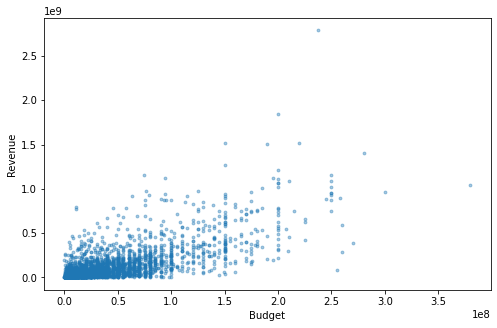

In [222]:
# visualize the data
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(1, 1, 1)

ax.scatter(X, y, s=8, alpha=0.4)
ax.set_xlabel('Budget')
ax.set_ylabel('Revenue') 

plt.show()

In [223]:
# divide the data to training and test sets. 80/20 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train.reshape(-1,1)
X_test.reshape(-1,1)
print(X_train.shape)
print(X_test.shape)

(2539, 1)
(635, 1)


coefficient: [3.04825748]
intercept: -2054080.3
accuracy: 0.472


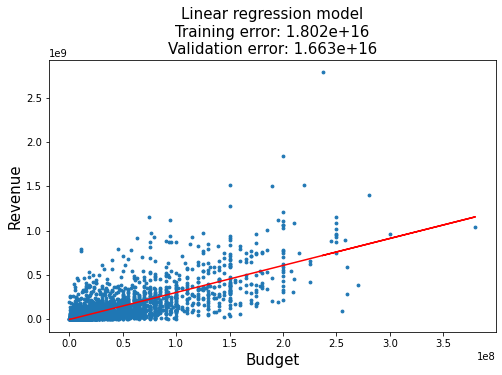

In [224]:
regr = LinearRegression()
regr.fit(X_train, y_train)
y_pred = regr.predict(X_train)
y_pred_test = regr.predict(X_test)
tr_error = mean_squared_error(y_train, y_pred)
test_error = mean_squared_error(y_test,y_pred_test)

plt.figure(figsize=(8, 5))
plt.scatter(X, y, s=8) 
plt.plot(X, (regr.coef_*X+regr.intercept_), color='r')  
plt.xlabel('Budget',size=15)
plt.ylabel('Revenue',size=15)

plt.title(f'Linear regression model\nTraining error: {tr_error:.4}\nValidation error: {test_error:.4}',size=15)
print(f"coefficient: {regr.coef_}")   # print the learnt w1
print(f"intercept: {regr.intercept_:.8}") # print the learnt w0
print(f"accuracy: {regr.score(X_test,y_test):.3}") # print the accuracy of the model

plt.show()

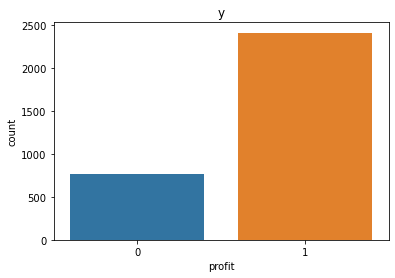

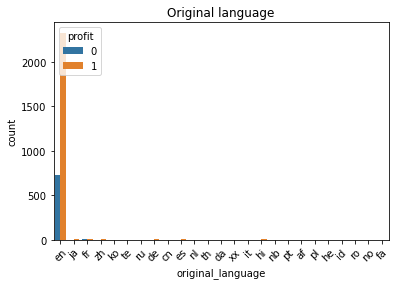

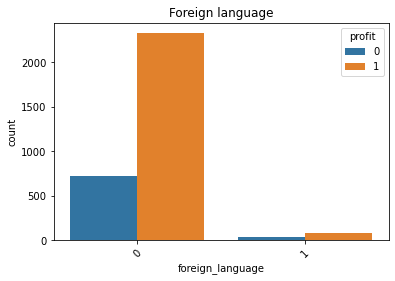

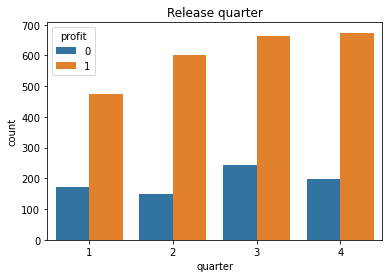

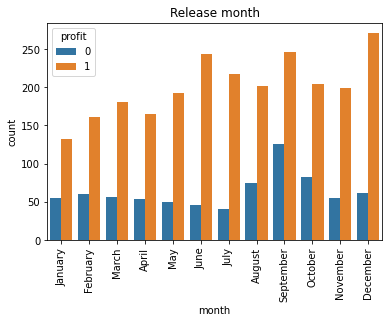

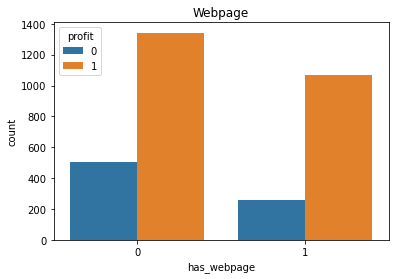

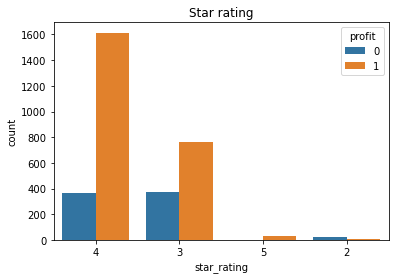

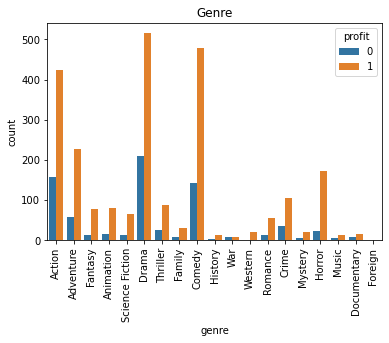

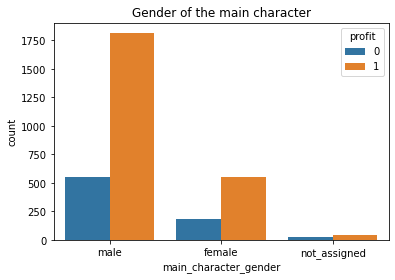

In [225]:
# Visualize the label
sns.countplot(x=data["profit"])
plt.title("y")
plt.show()

# Visualize some features
sns.countplot(data=data, x="original_language", hue="profit")
plt.xticks(rotation = 45)
plt.title("Original language")
plt.show()

sns.countplot(data=data, x="foreign_language", hue="profit")
plt.xticks(rotation = 45)
plt.title("Foreign language")
plt.show()

sns.countplot(data=data, x="quarter", hue="profit")
plt.title("Release quarter")
plt.show()

month_names = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']
sns.countplot(data=data, x="month", hue="profit", order=month_names)
plt.title("Release month")
plt.xticks(rotation = 90)
plt.show()

sns.countplot(data=data, x="has_webpage", hue="profit")
plt.title("Webpage")
plt.show()

sns.countplot(data=data, x="star_rating", hue="profit")
plt.title("Star rating")
plt.show()

sns.countplot(data=data, x="genre", hue="profit")
plt.title("Genre")
plt.xticks(rotation = 90)
plt.show()

sns.countplot(data=data, x="main_character_gender", hue="profit")
plt.title("Gender of the main character")
plt.show()

In [226]:
X_dt = data[data.columns]
X_dt = data[['original_language','month','star_rating','main_character_gender','genre','has_webpage',]] # select wanted features
y_dt = data['profit'].to_numpy() # set profit as label

X_dt = pd.get_dummies(X_dt)
print(X_dt.shape)
X_dt.head()

(3174, 64)


,has_webpage,original_language_af,original_language_cn,original_language_da,original_language_de,original_language_en,original_language_es,original_language_fa,original_language_fr,original_language_he,...,genre_Foreign,genre_History,genre_Horror,genre_Music,genre_Mystery,genre_Romance,genre_Science Fiction,genre_Thriller,genre_War,genre_Western
0,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [227]:
# train test split
X_dt_train, X_dt_test, y_dt_train, y_dt_test = train_test_split(X_dt, y_dt, test_size = 0.3, random_state=True)

print(X_dt_train.shape)
print(X_dt_test.shape)

(2221, 64)
(953, 64)


In [228]:
clf = DecisionTreeClassifier(random_state=0, max_depth=20, max_leaf_nodes=20)
clf.fit(X_dt_train, y_dt_train)
y_dt_train_pred = clf.predict(X_dt_train)
y_dt_test_pred = clf.predict(X_dt_test)

Training accuracy: 0.7712742008104457
Test accuracy: 0.7838405036726128


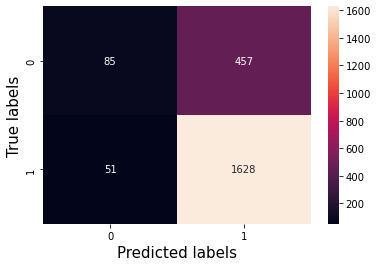

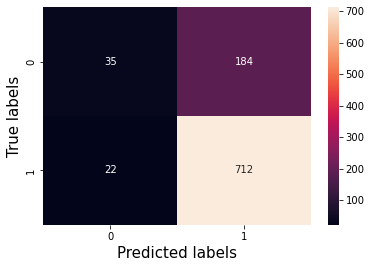

In [229]:
train_accuracy = accuracy_score(y_dt_train, y_dt_train_pred)
train_confmat = confusion_matrix(y_dt_train, y_dt_train_pred)
print("Training accuracy:", train_accuracy)

test_accuracy = accuracy_score(y_dt_test, y_dt_test_pred)
test_confmat = confusion_matrix(y_dt_test, y_dt_test_pred)
print("Test accuracy:", test_accuracy)

# plot the confusion matrices
ax = plt.subplot()
sns.heatmap(train_confmat,annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels',fontsize=15)
ax.set_ylabel('True labels',fontsize=15)
plt.show()

ax = plt.subplot()
sns.heatmap(test_confmat,annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels',fontsize=15)
ax.set_ylabel('True labels',fontsize=15)
plt.show()

In [230]:
# save as pdf for a high res image:
import pydotplus
d_tree = export_graphviz(clf, feature_names = list(X_dt.columns), filled = True, class_names=["profit", "loss"])
pydot_graph = pydotplus.graph_from_dot_data(d_tree)
pydot_graph.write_pdf('profit_tree.pdf')

Fontconfig error: Cannot load default config file: No such file: (null)



True